In [1]:
from load_data import load_data
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
from vispy.color import ColorArray
from PIL import Image

In [58]:
%config Completer.use_jedi = False

In [2]:
def print_image(image_data):
    plt.imshow(image_data, interpolation='nearest')
    plt.show()

In [3]:
#data = load_data(os.getcwd()+"/data/demo.p")
data = load_data(os.getcwd()+"/data/demo.p")
velodyne =  data['velodyne']
objects = data['objects']
print("The first 3 dimensions represent x,y,z and the last one represents the reflectance intensity  between 0 - 1")
print("Shape is "+ str(velodyne.shape))
print("We know that the maximum range is 120 m" )
num_of_points = velodyne.shape[0]

The first 3 dimensions represent x,y,z and the last one represents the reflectance intensity  between 0 - 1
Shape is (125897, 4)
We know that the maximum range is 120 m


## Task 1 Bird's Eye of View

In [145]:
# ==============================================================================
#                                                                   SCALE_TO_255
# ==============================================================================
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)

In [174]:
# ==============================================================================
#                                                          BIRDS_EYE_POINT_CLOUD
# ==============================================================================
def BEV_from_cloud(points, saveto , side_range = 0,fwd_range= 0,res = 0 ,min_height= 0, max_height=0):
    """ Creates an 2D birds eye view representation of the point Lidar 3D cloud data.
        You can optionally save the image to specified filename.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z and the intensity value/reflectance
                    shape is n x 4
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (float) desired resolution in metres to use
                    Each output pixel will represent an square region res x res
                    in size.
        min_height:  (float)(default=-2.73)
                    Used to truncate height values to this minumum height
                    relative to the sensor (in metres).
                    The default is set to -2.73, which is 1 metre below a flat
                    road surface given the configuration in the kitti dataset.
        max_height: (float)(default=1.27)
                    Used to truncate height values to this maximum height
                    relative to the sensor (in metres).
                    The default is set to 1.27, which is 3m above a flat road
                    surface given the configuration in the kitti dataset.
        saveto:     (str or None)(default=None)
                    Filename to save the image as.
                    If None, then it just displays the image.
    """
    max_velodyne = np.amax(points, 0)
    max_x = max_velodyne [0]
    max_y = max_velodyne [1]
    max_z = max_velodyne [2]
    min_velodyne = np.amin(points, 0)
    min_x = min_velodyne [0]
    min_y = min_velodyne [1]
    min_z = min_velodyne [2]


    #Assign to the corresponding variables
    side_range =(min_y ,max_y )
    fwd_range = (min_x , max_x)
    max_height = max_z
    min_height = min_z
    
    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    r_lidar = points[:, 3]  # Reflectance
    
    #side_range = range_of_vec(points[:,1])
    #fwd_range = range_of_vec(points[:,0])
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_lidar/res).astype(np.int32) # x axis is -y in LIDAR
    y_img = (x_lidar/res).astype(np.int32)  # y axis is -x in LIDAR
                                                     # will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img -= int(np.floor(side_range[0]/res))
    y_img -= int(np.floor(fwd_range[0]/res))



    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    #pixel_values  = scale_to_255(z_lidar, min=min_height, max=max_height)
    pixel_values = scale_to_255(r_lidar,min=0.0,max=1.0)
    
    # FILL PIXEL VALUES IN IMAGE ARRAY
    x_max = int((side_range[1] - side_range[0])/res)
    y_max = int((fwd_range[1] - fwd_range[0])/res)
    img = np.zeros([y_max, x_max], dtype=np.uint8)
    img[-y_img, x_img] = pixel_values # -y because images start from top left


    
    # SAVE THE IMAGE
    if saveto == "no":
        img = Image.fromarray(img)
        return img
    else :
        if saveto :
            cv2.imwrite(saveto, img) 
            print("The file is saved under ", saveto)
        else:
            cv2.imshow('image', img)
            cv2.waitKey(10000)
            print("You can view the BEV from the 3D Lidar points")
    

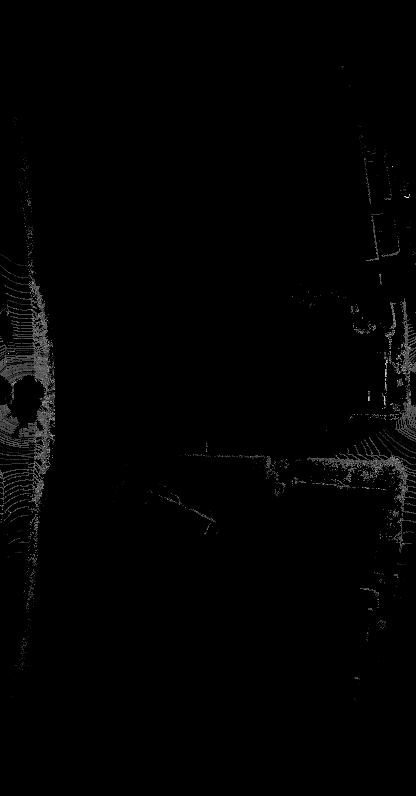

In [203]:
#Convert the 3D Lidar points to BEV view
img = BEV_from_cloud(velodyne , res = 0.2 , saveto = "no")
img

## Task 2.1 3D Lidar Point Cloud Projection to 2D image

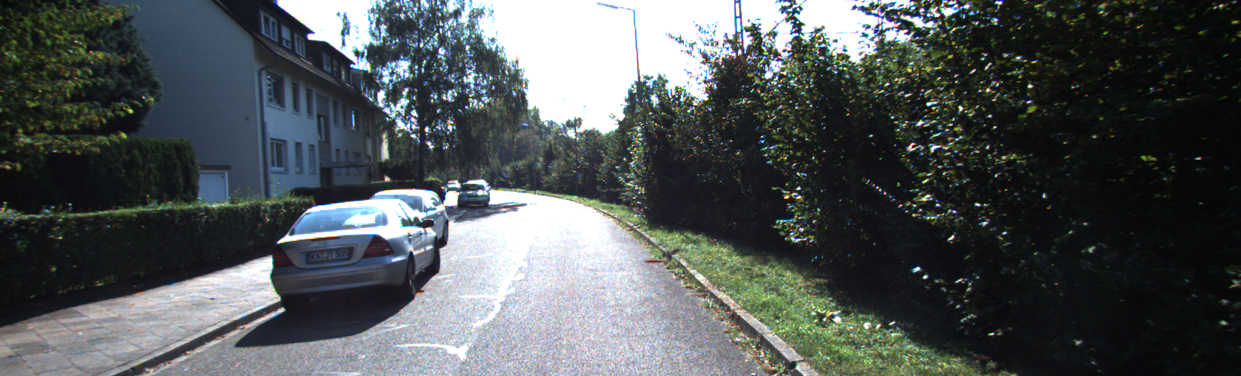

In [232]:
data = load_data('data/demo.p') # Change to data.p for your final submission 
img = data["image_2"]
R1 = data["T_cam2_velo"] # this consitutes our extrinsic parameters matrix
R2 = data["P_rect_20"] #this constitues our intrinsic parameters matrix
# Both R1 and R2 constitute the camera calibration of our scene that helps project the 3D lidar points to a 2D image plane
im = Image.fromarray(np.uint8(img), "RGB")
display(im)

In [ ]:
velodyne = data['velodyne']
pard direction only => Filter out the points of the backward direction
ind = points[:,0]>=0 # keep only the points that have an x>=0
points = points[ind] #keep the points only with the corresponding indeces
label_clip = data['sem_label'][ind] # get the semantic labels for each point of the cloud

oints = velodyne [:,:-1] # keep only the 3 dimensions of velodyne data 
# Forward direction only => Filter out the points of the backward direction
ind = points[:,0]>=0 # keep only the points that have an x>=0
points = points[ind] #keep the points only with the corresponding indeces
label_clip = data['sem_label'][ind] # get the semantic labels for each point of the cloud


# Homonegenous
P = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
# Multiply different parameter matrices to project 3D points on the 2D camera 2 image

#Extrinsic & intrinsic
print("The shape of the homogenous lidar points is ", P.shape)
print("The shape of the intrinsic matrix is ", R2.shape)
print("The shape of the extrinsic matrix is ", R1.shape)

P_2 = np.empty(points.shape)

for ind,point in enumerate(P):
    # Projection
    P_2[ind,:] = np.dot(np.dot(R2,R1),point)  # project for each point of the the Lidar = (1x3)
    # Normalization
    P_2[ind,:] = P_2[ind,:]/P_2[ind,-1] #normalize with the last element, to end up with 1 in the last dimension -> homogenous coordinates

print("The final 2D projected data have shape ", P_2.shape)

P_2 = P_2.astype(int)


#Get image and display it
img = data['image_2']
print( "our image is ", img.dtype)
img = np.uint8(img) #convert uint32 to uint8 with RGB channels
print( "our image is ", img.dtype)
cv2.imshow('image' , img)
cv2.waitKey(10000)

# Filter out ones not inside the perspective
ind_x = np.logical_and(P_2[:,1] < img.shape[0], P_2[:,1] >= 0)
ind_y = np.logical_and(P_2[:,0] < img.shape[1], P_2[:,0] >= 0)
ind_z = P_2[:,-1]>=0
ind = np.logical_and(ind_x,ind_y)
ind = np.logical_and(ind,ind_z)

#Convert the index to integer
P_clip = P_2[ind].astype(int)
label_clip = label_clip[ind]

# Color for each pixel position
color = np.empty([P_clip.shape[0],3])
for ind,label in enumerate(label_clip):
    color[ind,:] = data['color_map'][label[0]]
    color[ind,:] = [color[ind,-1],color[ind,1],color[ind,0]]
#color = ColorArray(color,clip=True)

for i,point in enumerate(projected_cloud_pixels):
    u = point[1] # corresponds to y
    v = point[0] # corresponds to x 
    img = cv2.circle(img, (v,u), radius=1, color=color[i,:] , thickness=1) # make pixels more visible
    #img[point[1],point[0],:] = color[i,:]


In [ ]:
img = Image.fromarray(np.uint8(img), "RGB")
img


## Task 2.2 3D bbox on 2D image

In [ ]:
data = load_data('data/demo.p') # Change to data.p for your final submission 
img = data["image_2"]
R1 = data["T_cam2_velo"]
R2 = data["P_rect_20"]
im = Image.fromarray(np.uint8(img), "RGB")

objects = data['objects']
corners = np.empty([len(objects),8,3])
i = 0
for individual in objects:
    '''3 dimensions 3D object dimensions: height, width, length (in meters)
    3 location 3D object location x,y,z in Cam 0 coordinates (in meters) describing the center
    of the bottom face of the bounding box'''
    # Height, Width, Length 
    dimension = np.array(individual[8:11])
    bbox_height = dimension[0]
    bbox_width = dimension[1]
    bbox_length =  dimension[2]
    # Right, Down, Front (X,Y,Z)
    location = np.array(individual[11:14])
    bbox_x = location[0]
    bbox_y = location[1]
    bbox_z = location[2]
    rotation_y = individual[14]
    corner = np.zeros([8,3])
    corner[0,:] = location + np.array([bbox_width/2,-bbox_height, bbox_length/2])
    corner[1,:] = corner[0,:] + np.array([-bbox_width ,0 , 0])
    corner[2,:] = corner[1,:] + np.array([0 ,0,-bbox_length])
    corner[3,:] = corner[2,:] + np.array([bbox_width, 0, 0])
    corner[4,:] = corner[0,:] + np.array([0, bbox_height ,0])
    corner[5,:] = corner[4,:] + np.array([-bbox_width,0, 0])
    corner[6,:] = corner[5,:] + np.array([0,0,-bbox_length])
    corner[7,:] = corner[6,:] + np.array([bbox_width,0,0])
    # Rotate along the y-axis
    #R = np.array([[1,0,0],[0,np.cos(rotation_y),np.sin(rotation_y)],[0,-np.sin(rotation_y),np.cos(rotation_y)]])
    #ind = 0
    #for point in corner:
    #    corner[ind,:] = np.dot(R,point)
    #    ind += 1
    corners[i,:,:] = corner
    i += 1
#R = data['P_rect_00']
T = np.eye(4)
T[0,3] = 0.06
for bbox in corners:
    for ind,pt in enumerate(bbox):
        pos = np.dot(np.dot(R2,T),np.concatenate((pt,[1])))
        pos /= pos[-1]
        pos = pos.astype(int)
        bbox[ind]=pos
   
corners = corners.astype(int,copy=False)


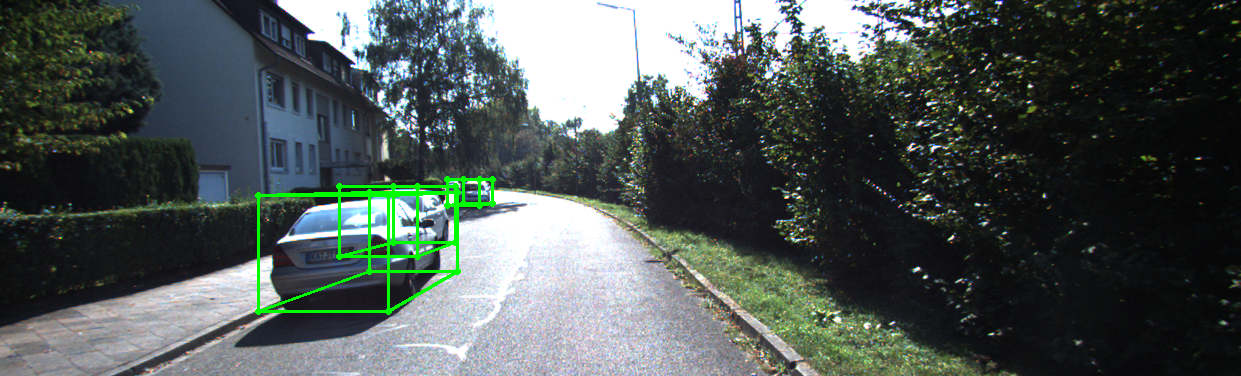

In [12]:
thickness = 2
color = (0,255,0)
radius = 2
for box in corners:
    for corner in box:
        img = cv2.circle(img,tuple(corner[:-1]),radius,color,thickness)
    # (0,1),(0,3),(0,4),(1,2),(1,5),(2,3),(2,6),(3,7),(4,5),(4,7),(5,6),(6,7)

    img = cv2.line(img,tuple(box[0,:-1].astype(int)),tuple(box[1,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[0,:-1].astype(int)),tuple(box[3,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[0,:-1].astype(int)),tuple(box[4,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[1,:-1].astype(int)),tuple(box[2,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[1,:-1].astype(int)),tuple(box[5,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[2,:-1].astype(int)),tuple(box[3,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[2,:-1].astype(int)),tuple(box[6,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[3,:-1].astype(int)),tuple(box[7,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[4,:-1].astype(int)),tuple(box[5,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[4,:-1].astype(int)),tuple(box[7,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[5,:-1].astype(int)),tuple(box[6,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[6,:-1].astype(int)),tuple(box[7,:-1].astype(int)),color,thickness)

im = Image.fromarray(np.uint8(img), "RGB")
display(im)


In [13]:
import vispy
from vispy.scene import visuals, SceneCanvas
import numpy as np
import os
from load_data import load_data

class Visualizer():
    def __init__(self):
        self.canvas = SceneCanvas(keys='interactive', show=True)
        self.grid = self.canvas.central_widget.add_grid()
        self.view = vispy.scene.widgets.ViewBox(border_color='white',
                        parent=self.canvas.scene)
        self.grid.add_widget(self.view, 0, 0)

        # Point Cloud Visualizer
        self.sem_vis = visuals.Markers()
        self.view.camera = vispy.scene.cameras.TurntableCamera(up='z', azimuth=90)
        self.view.add(self.sem_vis)
        visuals.XYZAxis(parent=self.view.scene)
        
        # Object Detection Visualizer
        self.obj_vis = visuals.Line()
        self.view.add(self.obj_vis)
        self.connect = np.asarray([[0,1],[0,3],[0,4],
                                   [2,1],[2,3],[2,6],
                                   [5,1],[5,4],[5,6],
                                   [7,3],[7,4],[7,6]])

    def update(self, points):
        '''
        :param points: point cloud data
                        shape (N, 3)          
        Task 2: Change this function such that each point
        is colored depending on its semantic label
        '''
        # Multiply different parameter matrices to project 3D points on the 2D camera 2 image

        data = load_data('data/demo.p') # Change to data.p for your final submission 
        P = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
        # Multiply different parameter matrices to project 3D points on the 2D camera 2 image
        P_2 = np.empty(points.shape)
        R2 = data['P_rect_20'] #intrinsic
        R1 = data['T_cam0_velo'] #extrinsic
        for ind,point in enumerate(P):
            # Projection
            P_2[ind,:] = np.dot(np.dot(R2,R1),point)
            # Normalization
            P_2[ind,:] = P_2[ind,:]/P_2[ind,-1]

        # Filter out ones not inside the perspective
        img = data['image_2']
        ind_x = np.logical_and(P_2[:,1] <= img.shape[0], P_2[:,1] >= 0)
        ind_y = np.logical_and(P_2[:,0] <= img.shape[1], P_2[:,0] >= 0)
        ind = np.logical_and(ind_x,ind_y)

        # Convert the index to integer
        P_clip = P_2[ind].astype(int)
        label_clip = data['sem_label'][ind]

        # Color for each pixel position
        color = np.empty([P_clip.shape[0],3])
        for ind,label in enumerate(label_clip):
            color[ind,:] = data['color_map'][label[0]]
        color = ColorArray(color,clip=True)
        self.sem_vis.set_data(P_clip,edge_color=color, size=3)
                
    
    def update_boxes(self, corners):
        '''
        :param corners: corners of the bounding boxes
                        shape (N, 8, 3) for N boxes
        (8, 3) array of vertices for the 3D box in
        following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
        If you plan to use a different order, you can
        change self.connect accordinly.
        '''
        for i in range(corners.shape[0]):
            connect = np.concatenate((connect, self.connect+8*i), axis=0) \
                      if i>0 else self.connect
        self.obj_vis.set_data(corners.reshape(-1,3),
                              connect=connect,
                              width=2,
                              color=[0,1,0,1])

In [14]:
    data = load_data('data/demo.p') # Change to data.p for your final submission 
    visualizer = Visualizer()
    visualizer.update(data['velodyne'][:,:3])
    '''
    Task 2: Compute all bounding box corners from given
    annotations. You can visualize the bounding boxes using
    visualizer.update_boxes(corners)
    '''
    vispy.app.run()


## Task 3 Laser ID

In [11]:
lines_of_search = 64 
data =load_data("data/demo.p")
velodyne = data['velodyne']

def convert_rad_to_deg(value):
    return value * 57.2958

def range_of(array):
    print(array.shape)
    max_ = np.amax(array)
    min_ = np.amin(array)
    return tuple([min_,max_])
# According to the VELODYNE HDL datashet HDL-64E
min_FOV = -24.9
max_FOV = 2.0
FOV = max_FOV - min_FOV
# so this gives us a range for our theta angle and we have to divide each 3D point to which part of the FOV it belongs to
FOV_interval = FOV/lines_of_search
angle = 2.0
theta = []
# Divide the angles in different bins. Seperate bins with interval of approximately 2 degrees (according to calculation)
for i in range(0 ,lines_of_search):
    theta.append(angle)
    angle -= FOV_interval
theta_vector =np.array(theta)

#Find which points belong to which FOV lines, depending on their atan
# we only need x (the forward direction) and z (the upward direction)
x = velodyne[: ,0]
z = velodyne[: ,2]
index = z>=0
x = x[index]
z = z[index]
#keep also corresponding indeces for x
print(x[0] , z[0])
tan_values = np.divide (z , x)
theta_of_points = np.arctan(tan_values) # get the angles in radians for all points
theta_deg_of_points = convert_rad_to_deg(theta_of_points) # get the agnels in degrees for all points
print(range_of(theta_deg_of_points))

#Filter out indexes that are outside this range 
index = np.logical_and(max_FOV>=theta_deg_of_points , theta_deg_of_points >=min_FOV)
theta_deg_of_points = theta_deg_of_points[index]
line_ids = np.array(theta_deg_of_points.shape)
print(theta_vector.shape)
list_theta_range= []
for i in range(1, theta_vector.shape[0]):
    list_theta_range.append([theta_vector[i], theta_vector[i-1]])
theta_vector_ranges = np.array(list_theta_range)



for i , theta_range in enumerate(theta_vector_ranges):
    max_theta = theta_range[0]
    min_theta = theta_range[1]
    index_bin = np.logical_and(theta_deg_of_points<=min_theta , theta_deg_of_points>=max_theta) #find index of points that match this bin
    print(index_bin)
    line_ids.append(index_bin)
    
    #replace points with this index with appropriate line ID




33.36268 1.3370247
(20865,)
(-89.99759, 89.715805)
(64,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 12923